In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
tqdm.pandas()

In [2]:
csv_ffiv = "C:/Business analysis/Project/IS403.O22.HTCLL_Nhom07/Dataset/ffiv_Stock.csv"
df_ffiv = pd.read_csv(csv_ffiv, thousands=',')

In [3]:
df_ffiv.head()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
0,3/1/2019,FFIV,166.529999,166.529999,168.330002,165.419998,167.600006,756400
1,3/4/2019,FFIV,163.289993,163.289993,167.289993,161.710007,166.970001,553700
2,3/5/2019,FFIV,162.149994,162.149994,163.399994,161.970001,163.240005,511300
3,3/6/2019,FFIV,161.080002,161.080002,162.139999,159.949997,161.919998,527000
4,3/7/2019,FFIV,158.990005,158.990005,161.250000,157.910004,160.630005,783200


In [4]:
df_ffiv.describe()

,Adj Close,Close,High,Low,Open,Volume
count,1324.000000,1324.000000,1324.000000,1324.000000,1324.000000,1.324000e+03
mean,163.434992,163.434992,165.268542,161.482228,163.397160,6.147710e+05
std,29.329932,29.329932,29.577160,29.115418,29.336975,3.981027e+05
min,90.550003,90.550003,93.830002,79.779999,88.750000,1.205000e+05
25%,141.537506,141.537506,143.384998,139.952503,141.632496,3.971500e+05
50%,155.590004,155.590004,157.345001,154.154999,156.070000,5.293500e+05
75%,186.022503,186.022503,187.654995,184.379997,186.260002,6.974750e+05
max,247.779999,247.779999,249.000000,245.899994,247.779999,5.232700e+06


In [5]:
df_ffiv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324 entries, 0 to 1323
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1324 non-null   object 
 1   Symbol     1324 non-null   object 
 2   Adj Close  1324 non-null   float64
 3   Close      1324 non-null   float64
 4   High       1324 non-null   float64
 5   Low        1324 non-null   float64
 6   Open       1324 non-null   float64
 7   Volume     1324 non-null   int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 82.9+ KB


In [6]:
# Convert object to datetime64
df_ffiv['Date'] = df_ffiv['Date'].apply(pd.to_datetime)
# Sort data by date time value
df_ffiv = df_ffiv.sort_values(by="Date").reset_index(drop=True)
df_ffiv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324 entries, 0 to 1323
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1324 non-null   datetime64[ns]
 1   Symbol     1324 non-null   object        
 2   Adj Close  1324 non-null   float64       
 3   Close      1324 non-null   float64       
 4   High       1324 non-null   float64       
 5   Low        1324 non-null   float64       
 6   Open       1324 non-null   float64       
 7   Volume     1324 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 82.9+ KB


In [7]:
df_ffiv.Close

0       166.529999
1       163.289993
2       162.149994
3       161.080002
4       158.990005
           ...    
1319    168.339996
1320    168.229996
1321    167.300003
1322    168.970001
1323    166.910004
Name: Close, Length: 1324, dtype: float64

In [8]:
rows = []
for _,row in tqdm(df_ffiv.iterrows(), total=df_ffiv.shape[0]):
    row_data = dict(
        day = row.Date.day,
        month = row.Date.month,
        year = row.Date.year,
        open = row.Open,
        low = row.Close,
        high = row.High, 
        close = row.Close, 
        volume = row.Volume
    )
    rows.append(row_data)
features_ffiv = pd.DataFrame(rows)

  0%|          | 0/1324 [00:00<?, ?it/s]

In [9]:
features_ffiv.head()

,day,month,year,open,low,high,close,volume
0,1,3,2019,167.600006,166.529999,168.330002,166.529999,756400
1,4,3,2019,166.970001,163.289993,167.289993,163.289993,553700
2,5,3,2019,163.240005,162.149994,163.399994,162.149994,511300
3,6,3,2019,161.919998,161.080002,162.139999,161.080002,527000
4,7,3,2019,160.630005,158.990005,161.250000,158.990005,783200


In [10]:
def detect_outlier(df, col):
    q1 = np.percentile(df[col], 25)
    q3 = np.percentile(df[col], 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    print(df[(df[col] < lower_bound) | (df[col] > upper_bound)])

In [11]:
detect_outlier(features_ffiv, 'close')

Empty DataFrame
Columns: [day, month, year, open, low, high, close, volume]
Index: []


In [12]:
train_size = int(0.75 * len(features_ffiv))
test_size = len(features_ffiv)-train_size

train_ffiv_df = features_ffiv[:train_size]
test_ffiv_df = features_ffiv[train_size:]

In [13]:
#Quá trình Training
x_train = np.array(train_ffiv_df.index).reshape(-1, 1)
y_train = np.array(train_ffiv_df['close'])
# Train the linear regression model
model = LinearRegression()
model.fit(x_train, y_train)
# In các thông số của mô hình
print("Hệ số hồi quy (slope):", model.coef_)
print("Sai số chệch (intercept):", model.intercept_)

Hệ số hồi quy (slope): [0.04920949]
Sai số chệch (intercept): 139.65428782375068


In [14]:
#Quá trình testing
x_test = np.array(test_ffiv_df.index).reshape(-1, 1)
y_test = np.array(test_ffiv_df['close'])
y_pred = model.predict(x_test)

In [15]:
#Quá trình tạo index predict 30 ngày tiếp theo
last_index = features_ffiv.index[-1]
last_30_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(x_next_30_days)

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[204.80765398 204.85686347 204.90607296 204.95528245 205.00449194
 205.05370143 205.10291092 205.15212041 205.2013299  205.25053939
 205.29974889 205.34895838 205.39816787 205.44737736 205.49658685
 205.54579634 205.59500583 205.64421532 205.69342481 205.7426343
 205.7918438  205.84105329 205.89026278 205.93947227 205.98868176
 206.03789125 206.08710074 206.13631023 206.18551972 206.23472922]


In [16]:
#Quá trình tạo index predict 60 ngày tiếp theo
last_index = features_ffiv.index[-1]
last_60_data = pd.RangeIndex(start=last_index, stop=last_index+60, step=1)

# Create an array of 60 consecutive integers starting from last_index
x_next_60_days = np.array(range(last_index+1, last_index+61)).reshape(-1, 1)

# Predict the closing prices for the next 60 days
y_next_60_days = model.predict(x_next_60_days)

# Print the predicted closing prices for the next 60 days
print('Predicted closing prices for the next 60 days:')
print(y_next_60_days)

Predicted closing prices for the next 60 days:
[204.80765398 204.85686347 204.90607296 204.95528245 205.00449194
 205.05370143 205.10291092 205.15212041 205.2013299  205.25053939
 205.29974889 205.34895838 205.39816787 205.44737736 205.49658685
 205.54579634 205.59500583 205.64421532 205.69342481 205.7426343
 205.7918438  205.84105329 205.89026278 205.93947227 205.98868176
 206.03789125 206.08710074 206.13631023 206.18551972 206.23472922
 206.28393871 206.3331482  206.38235769 206.43156718 206.48077667
 206.52998616 206.57919565 206.62840514 206.67761463 206.72682413
 206.77603362 206.82524311 206.8744526  206.92366209 206.97287158
 207.02208107 207.07129056 207.12050005 207.16970955 207.21891904
 207.26812853 207.31733802 207.36654751 207.415757   207.46496649
 207.51417598 207.56338547 207.61259496 207.66180446 207.71101395]


In [17]:
#Quá trình tạo index predict 90 ngày tiếp theo
last_index = features_ffiv.index[-1]
last_90_data = pd.RangeIndex(start=last_index, stop=last_index+90, step=1)

# Create an array of 90 consecutive integers starting from last_index
x_next_90_days = np.array(range(last_index+1, last_index+91)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_90_days = model.predict(x_next_90_days)

# Print the predicted closing prices for the next 90 days
print('Predicted closing prices for the next 90 days:')
print(y_next_90_days)

Predicted closing prices for the next 90 days:
[204.80765398 204.85686347 204.90607296 204.95528245 205.00449194
 205.05370143 205.10291092 205.15212041 205.2013299  205.25053939
 205.29974889 205.34895838 205.39816787 205.44737736 205.49658685
 205.54579634 205.59500583 205.64421532 205.69342481 205.7426343
 205.7918438  205.84105329 205.89026278 205.93947227 205.98868176
 206.03789125 206.08710074 206.13631023 206.18551972 206.23472922
 206.28393871 206.3331482  206.38235769 206.43156718 206.48077667
 206.52998616 206.57919565 206.62840514 206.67761463 206.72682413
 206.77603362 206.82524311 206.8744526  206.92366209 206.97287158
 207.02208107 207.07129056 207.12050005 207.16970955 207.21891904
 207.26812853 207.31733802 207.36654751 207.415757   207.46496649
 207.51417598 207.56338547 207.61259496 207.66180446 207.71101395
 207.76022344 207.80943293 207.85864242 207.90785191 207.9570614
 208.00627089 208.05548038 208.10468988 208.15389937 208.20310886
 208.25231835 208.30152784 208.

In [18]:
#Evaluating algorithm accuracy using
#RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Testing RMSE:', test_rmse)

#MAE
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
print('Testing MAE:', test_mae)

#MAPE
from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(y_test, y_pred)
print('Testing MAPE:', test_mape)

Testing RMSE: 37.51455123409395
Testing MAE: 35.08549464546465
Testing MAPE: 0.22821201049403894


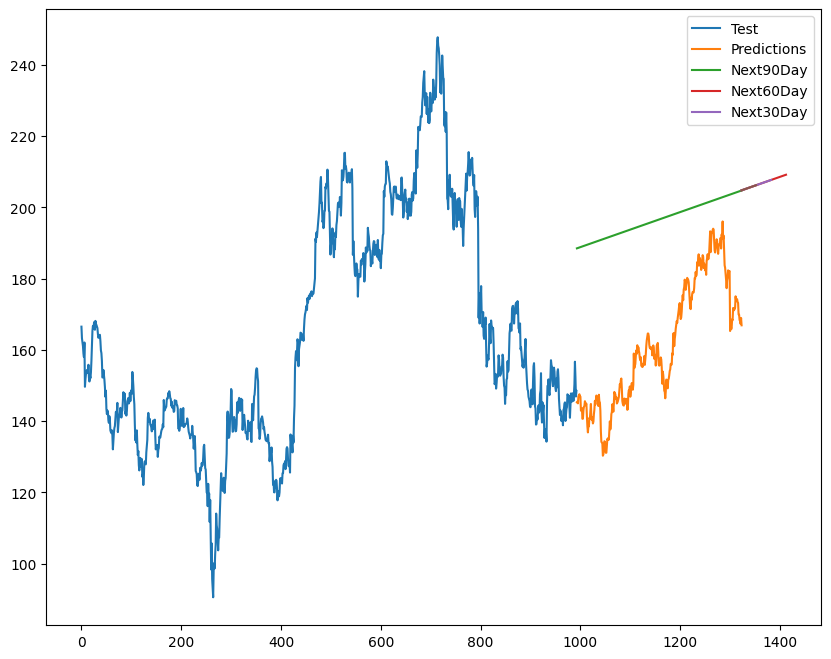

In [19]:
#Vẽ hình
plt.figure(figsize=(10, 8))
plt.plot(train_ffiv_df.index, train_ffiv_df['close'])
plt.plot(test_ffiv_df.index, test_ffiv_df['close'])
plt.plot(test_ffiv_df.index, y_pred)
plt.plot(last_90_data,y_next_90_days)
plt.plot(last_60_data,y_next_60_days)
plt.plot(last_30_data,y_next_30_days)
plt.legend(['Test', 'Predictions','Next90Day','Next60Day','Next30Day'])
plt.show()

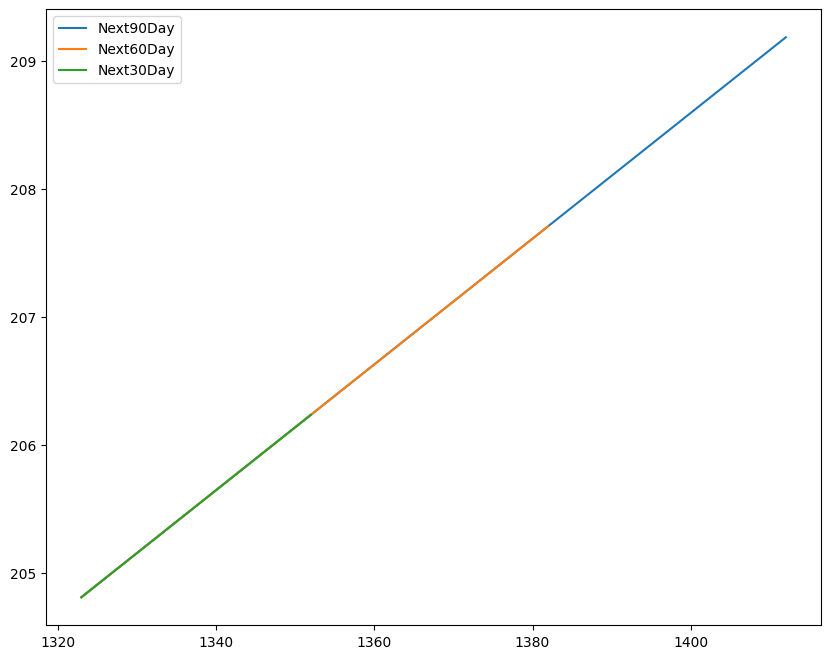

In [20]:
plt.figure(figsize=(10, 8))
plt.plot(last_90_data,y_next_90_days)
plt.plot(last_60_data,y_next_60_days)
plt.plot(last_30_data,y_next_30_days)
plt.legend(['Next90Day','Next60Day','Next30Day'])
plt.show()